In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from google.colab import drive
from PIL import Image

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
BASE_DIR = "/content/drive/My Drive/Clothing Segmentation"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoints", "deeplabv3_best.pth")
TEST_IMAGES_DIR = os.path.join(BASE_DIR, "dataset", "test", "images")
TEST_MASKS_DIR = os.path.join(BASE_DIR, "dataset", "test", "masks")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "dataset", "labels.csv")

In [ ]:
# Load class labels
if os.path.exists(LABELS_CSV_PATH):
    class_df = pd.read_csv(LABELS_CSV_PATH)
    class_names = class_df['label_list'].tolist()
else:
    class_names = [f"Class_{i}" for i in range(59)]  # Default for 59 classes

In [ ]:
NUM_CLASSES = len(class_names)
print(f"Number of classes detected: {NUM_CLASSES}")

# Load PyTorch DeepLabV3+ model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet50(num_classes=NUM_CLASSES, aux_loss=True)

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Remove auxiliary classifier weights from the checkpoint
filtered_checkpoint = {k: v for k, v in checkpoint.items() if "aux_classifier" not in k}

# Load the filtered state dictionary
missing_keys, unexpected_keys = model.load_state_dict(filtered_checkpoint, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

model.to(device)
model.eval()
print("Model successfully loaded!")

Number of classes detected: 59


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


Missing keys: ['aux_classifier.0.weight', 'aux_classifier.1.weight', 'aux_classifier.1.bias', 'aux_classifier.1.running_mean', 'aux_classifier.1.running_var', 'aux_classifier.4.weight', 'aux_classifier.4.bias']
Unexpected keys: []
Model successfully loaded!


In [ ]:
print("Before loading weights:", model.classifier[-1].out_channels)

Before loading weights: 59


In [30]:
# Preprocessing function for images
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Ensure consistency
    transforms.ToTensor(),           # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])


In [ ]:
def preprocess_image(image_path):
    """Load and preprocess an input image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = transform(image)
    return image

In [39]:
def calculate_iou(y_true, y_pred, num_classes=NUM_CLASSES):
    iou_scores = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        iou = intersection / union if union > 0 else 0
        print(f"Class {cls}: IoU = {iou:.4f}, Intersection = {intersection}, Union = {union}")
        iou_scores.append(iou)
    mean_iou = np.mean(iou_scores)
    print(f"Mean IoU: {mean_iou:.4f}")
    return iou_scores, mean_iou


In [44]:
def dice_coefficient(y_true, y_pred, num_classes=NUM_CLASSES, smooth=1e-6):
    """Calculate per-class and mean Dice coefficient with smoothing and debug prints."""
    dice_scores = []

    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        true_sum = np.sum(y_true == cls)
        pred_sum = np.sum(y_pred == cls)
        denominator = true_sum + pred_sum

        # Print debug information
        print(f"Class {cls}: Intersection={intersection}, True Pixels={true_sum}, Pred Pixels={pred_sum}, Denominator={denominator}")

        # Compute Dice with smoothing
        dice = (2 * intersection + smooth) / (denominator + smooth)
        dice_scores.append(dice)

    mean_dice = np.mean(dice_scores)

    print("Unique values in Ground Truth Mask:", np.unique(y_true))
    print("Unique values in Predicted Mask:", np.unique(y_pred))


    return dice_scores, mean_dice


In [45]:
from torchvision import transforms

def evaluate_single_image(model, image_path, mask_path, device, transform, target_size=(256, 256)):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")  # Ensure it's a PIL image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Apply transformations

    # Load and preprocess mask
    mask = Image.open(mask_path).convert("L")  # Ensure grayscale
    mask = np.array(mask.resize(target_size, Image.NEAREST))

    # Predict mask
    with torch.no_grad():
        output = model(image_tensor)

        # Extract tensor if model returns an OrderedDict
        if isinstance(output, dict):
            output = output["out"]

        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Compute IoU, Dice, and Pixel Accuracy
    intersection = np.logical_and(predicted_mask, mask).sum()
    union = np.logical_or(predicted_mask, mask).sum()
    iou = intersection / union if union > 0 else 0.0
    dice = (2 * intersection) / (predicted_mask.sum() + mask.sum()) if (predicted_mask.sum() + mask.sum()) > 0 else 0.0
    pixel_acc = np.mean(predicted_mask == mask)

    print(f"Evaluation for {os.path.basename(image_path)}:")
    print(f"Mean IoU: {iou:.4f}")
    print(f"Mean Dice Coefficient: {dice:.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")

    # Display real image, real mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(predicted_mask, cmap="jet")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()


Evaluation for img_0007.jpeg:
Mean IoU: 0.9297
Mean Dice Coefficient: 0.0331
Pixel Accuracy: 0.7437


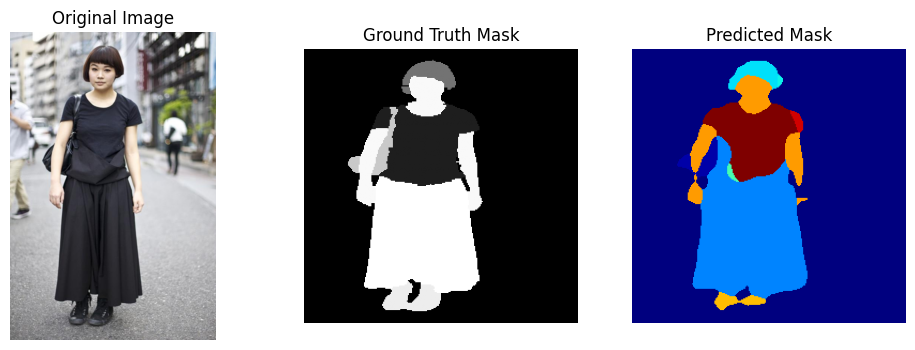

Evaluation for img_0026.jpeg:
Mean IoU: 0.9318
Mean Dice Coefficient: 0.0260
Pixel Accuracy: 0.8804


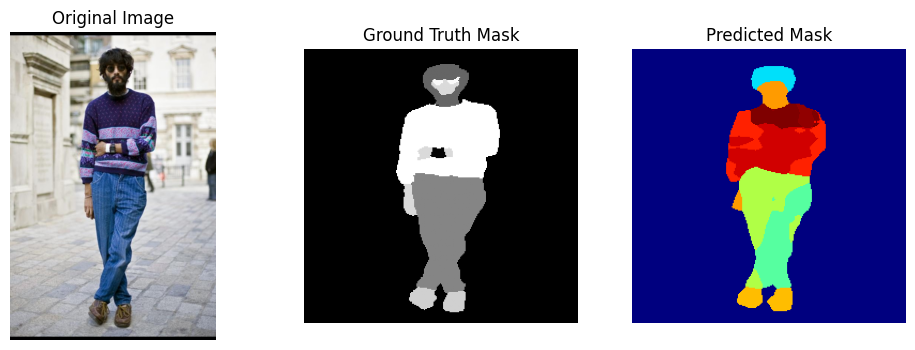

Evaluation for img_0028.jpeg:
Mean IoU: 0.9451
Mean Dice Coefficient: 0.0266
Pixel Accuracy: 0.9154


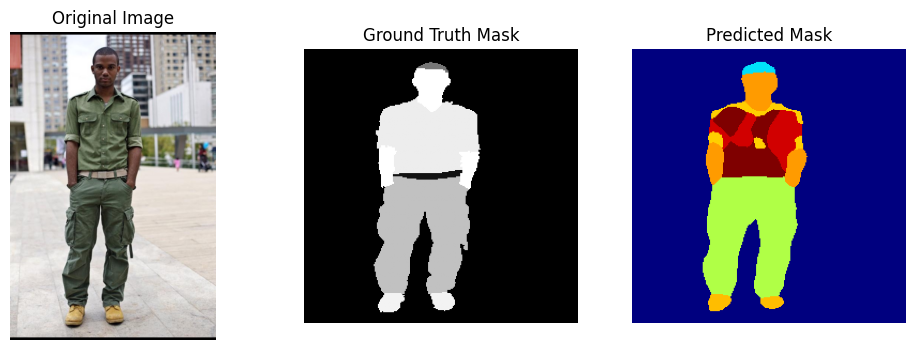

Evaluation for img_0031.jpeg:
Mean IoU: 0.9184
Mean Dice Coefficient: 0.0335
Pixel Accuracy: 0.8620


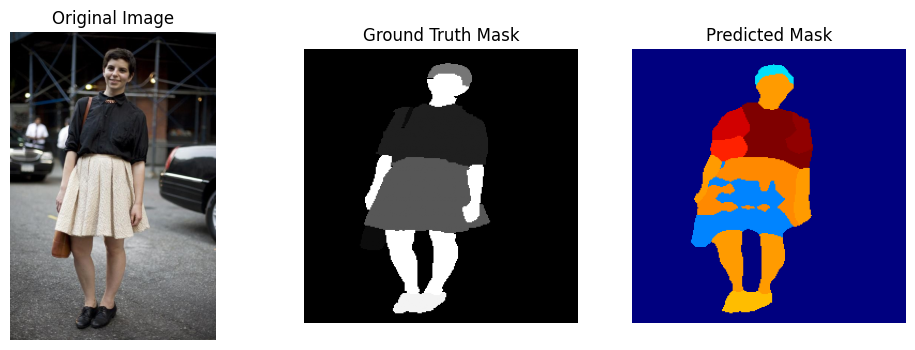

Evaluation for img_0033.jpeg:
Mean IoU: 0.8819
Mean Dice Coefficient: 0.0256
Pixel Accuracy: 0.8743


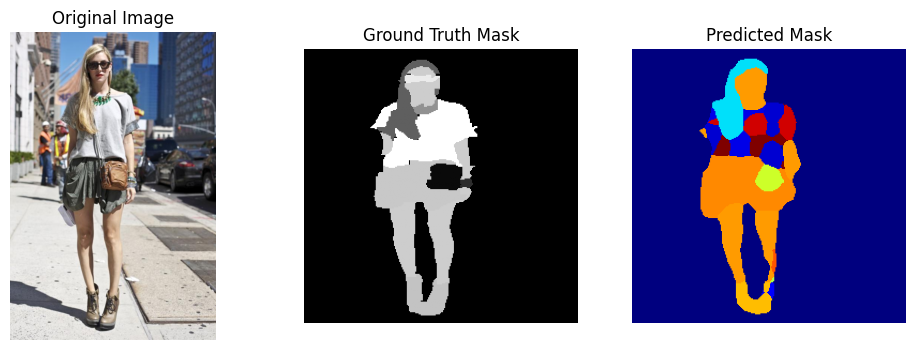

In [46]:
num_samples = min(5, len(os.listdir(TEST_IMAGES_DIR)))

for i in range(num_samples):
    image_path = os.path.join(TEST_IMAGES_DIR, sorted(os.listdir(TEST_IMAGES_DIR))[i])
    mask_path = os.path.join(TEST_MASKS_DIR, sorted(os.listdir(TEST_MASKS_DIR))[i])

    evaluate_single_image(model, image_path, mask_path, device, transform)



In [ ]:
checkpoint = torch.load(MODEL_PATH, map_location=device)
print(checkpoint.keys())  # List all keys in checkpoint


odict_keys(['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.bn3.weight', 'backbone.layer1.0.bn3.bias', 'backbone.layer1.0.bn3.running_mean', 'backbone.layer1.0.bn3.running_var', 'backbone.layer1.0.bn3.num_batches_tracked', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.0.downsample.1.running_mean', 'backbone.

In [ ]:
print("After loading weights:", model.classifier[-1].out_channels)


After loading weights: 59


In [ ]:
with torch.no_grad():
    output = model(torch.randn(1, 3, 256, 256).to(device))["out"]
    print("Unique values in prediction:", torch.unique(torch.argmax(output, dim=1)))


Unique values in prediction: tensor([0])


In [ ]:
print("Unique values in prediction:", torch.unique(torch.argmax(output, dim=1)))


Unique values in prediction: tensor([0])


In [ ]:
checkpoint = torch.load(MODEL_PATH, map_location=device)
print("Checkpoint keys:", checkpoint.keys())

missing, unexpected = model.load_state_dict(checkpoint, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)



Checkpoint keys: odict_keys(['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.bn3.weight', 'backbone.layer1.0.bn3.bias', 'backbone.layer1.0.bn3.running_mean', 'backbone.layer1.0.bn3.running_var', 'backbone.layer1.0.bn3.num_batches_tracked', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.0.downsample.1.running_

Input image shape: torch.Size([3, 256, 256])
Input image min/max: tensor(-2.1008) tensor(2.6400)
Input mask shape: torch.Size([256, 256])
Input mask unique values: tensor([ 0,  5, 19, 33, 39, 41, 42])


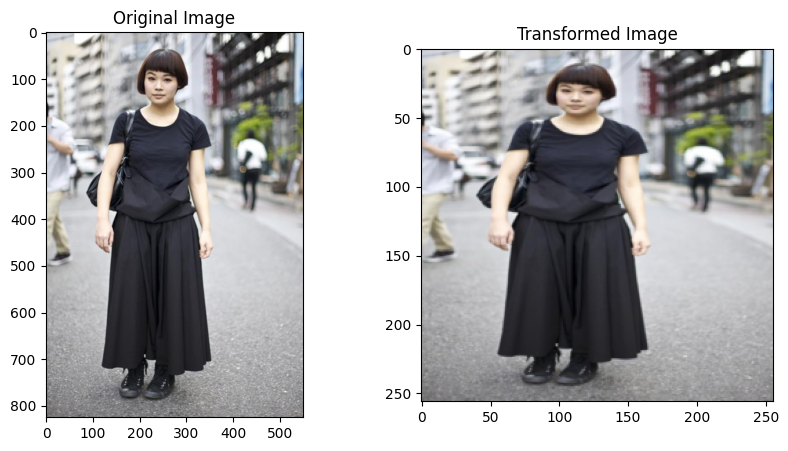

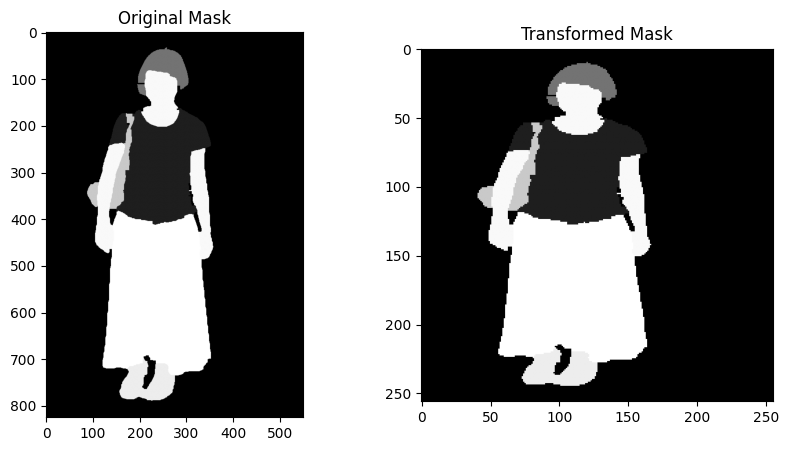

In [ ]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load an image and mask (Replace these with actual file paths)
IMAGE_PATH = os.path.join(BASE_DIR, "dataset", "test", "images", "img_0007.jpeg")  # Change this
MASK_PATH = os.path.join(BASE_DIR, "dataset", "test", "masks", "seg_0007.png")  # Change this

# Define transforms (Using your given transforms)
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Adjust if needed
image_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img)).long())
])

# Load images
original_image = Image.open(IMAGE_PATH).convert("RGB")
original_mask = Image.open(MASK_PATH).convert("L")

# Apply transformations
transformed_image = image_transform(original_image)
transformed_mask = mask_transform(original_mask)

# Print shapes and unique values
print("Input image shape:", transformed_image.shape)
print("Input image min/max:", transformed_image.min(), transformed_image.max())

print("Input mask shape:", transformed_mask.shape)
print("Input mask unique values:", torch.unique(transformed_mask))

# Visualize
def reverse_transform(tensor):
    tensor = tensor.permute(1, 2, 0).numpy()  # CHW → HWC
    tensor = tensor * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    tensor = np.clip(tensor, 0, 1)  # Clip values to [0,1]
    return tensor

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(reverse_transform(transformed_image))
plt.title("Transformed Image")

plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_mask, cmap="gray")
plt.title("Original Mask")

plt.subplot(1, 2, 2)
plt.imshow(transformed_mask, cmap="gray")
plt.title("Transformed Mask")

plt.show()

